# Evaluation Project - 5 : Census Income Project

#### Problem Statement:

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

#### Description of fnlwgt (final weight)

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

1.A single cell estimate of the population 16+ for each state.

2.Controls for Hispanic Origin by age and sex.

3.Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing  import power_transform, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import pickle
import warnings
warnings.filterwarnings('ignore')

## Importing the DATASET

In [2]:
census=pd.read_csv("https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv")

## Checking Top 5 rows Data

In [3]:
census.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


## EDA


### Checking Total Numbers of Rows and Column

In [4]:
census.shape

(32560, 15)

#### Checking All Column Names

In [5]:
census.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country',
       'Income'],
      dtype='object')

### Checking Data Type of All Data

In [6]:
census.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
Native_country    object
Income            object
dtype: object

### Checking for Null Values

In [7]:
census.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

**There is no null value present in our dataset**

### Checking for Null Values through heatmap also

<AxesSubplot:>

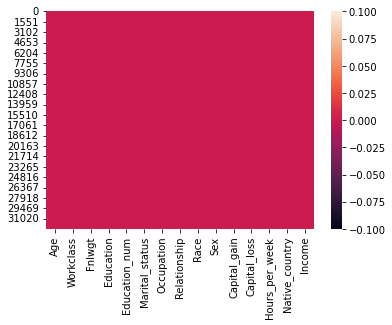

In [8]:
sns.heatmap(census.isnull())

We can check through visualization also that there is no Null Value present in our Dataset.

### Information about Data (Memory Used and Data Types)

In [9]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### Checking for blank value in our Target Column

In [10]:
census[census['Income'] == ''].index

Int64Index([], dtype='int64')

So, we can check there are no blank value present in our Target Column

In [11]:
# Checking whether the dataset contains any space
census.loc[census['Income']==" "]

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income


So we can see there are no spaces present in the dataset.

### Checking values of Target Variable.

In [12]:
census['Income'].value_counts()

 <=50K    24719
 >50K      7841
Name: Income, dtype: int64

In [13]:
census['Income'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [14]:
census['Income'].nunique()

2

Target variable contains two value: <=50k and >=50k

**checking for ? values in dataset as we can see there are 0 values in some columns and that is also a value. So, it is not showing while checking for null value. But we have to handle that 0 value with mean, mode or some other value.**

In [15]:
(census==' ?').sum()

Age                  0
Workclass         1836
Fnlwgt               0
Education            0
Education_num        0
Marital_status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_gain         0
Capital_loss         0
Hours_per_week       0
Native_country     583
Income               0
dtype: int64

* Now, we can see Column 'Workclass' contains 1836 ' ?' values, Column 'Occupation' contains 1843 ' ?' values and Column 'Native_country' contains 583 ' ?' values.
* So, we will convert these values into null value by replacing these with 'nan' to handle these 'null' values

In [16]:
census.replace({' ?': np.nan}, inplace=True)

### Checking again for Null values

In [17]:
census.isnull().sum()

Age                  0
Workclass         1836
Fnlwgt               0
Education            0
Education_num        0
Marital_status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_gain         0
Capital_loss         0
Hours_per_week       0
Native_country     583
Income               0
dtype: int64

So, now we can see null value is showing and we have to handle it.

### Descriptive Statistics

In [18]:
# Description of Dataset : works only on continuous column 
census.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


* We can check that 6 columns contains Continuous data: Age, Fnlwgt, Education_num, Capital_gain, Capital_loss, Hours_per_week.
* And 9 columns contains Categorical data: 'Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex','Native_country', 'Income'
* Here also we can see that there is no null value in aur dataset as count is 32560 in each column.


### Checking Description through heatmap also.

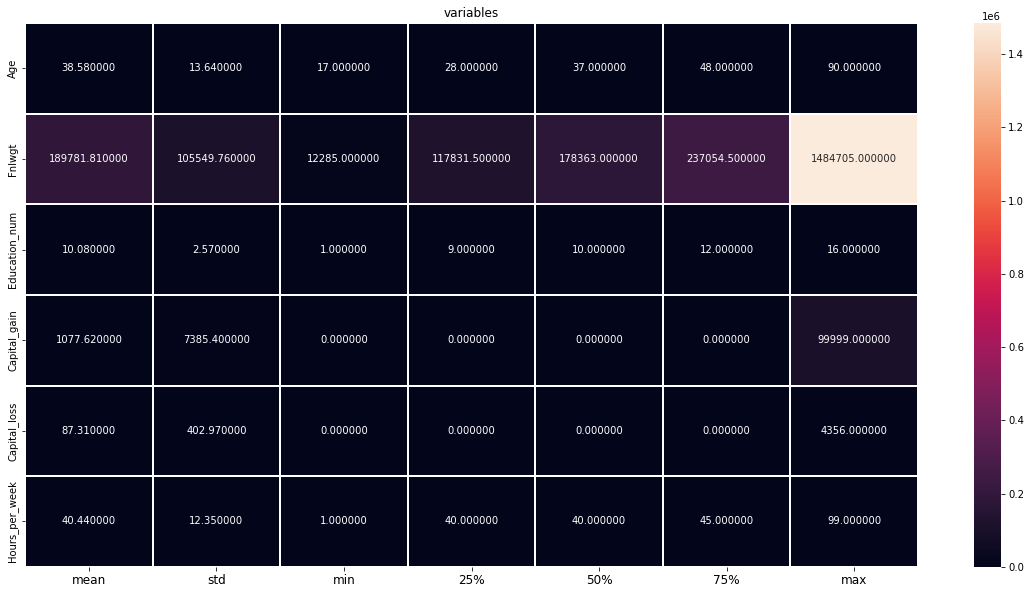

In [19]:
plt.figure(figsize=(20,10))
sns.heatmap(round(census.describe()[1:].transpose(),2),linewidth=2,annot=True,fmt='f')
plt.xticks(fontsize=18)
plt.xticks(fontsize=12)
plt.title('variables')
plt.show()

#### Observation of Describe of Datasets:
* We observe from description of dataset that there are 32560 rows and 15 columns, in which 6 columns contains Continuous data and 9 columns contains Categorical data.
* There are no negative value present in dataset but data is not normally distributed and also skewness is present.
* In column 'Capital_gain' and 'Capital_loss' min , 25%, 50%, 75% values are 0 which is invalid value as max value of 'Capital_gain' is 99999.000000 and max value of 'Capital_loss' is 4356.000000. Also Total count is 32560. So, we will check for value 0, as 0 value is also null value but it is value that why while checking for null value it is not counted.

## Data Cleaning and preprocessing

Since there are Null values in the dataset, so we need to treat them.

### Handling Null Values

In [20]:
#checking all values of column 'Workclass'
census["Workclass"].unique() 

array([' Self-emp-not-inc', ' Private', ' State-gov', ' Federal-gov',
       ' Local-gov', nan, ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [21]:
#checking repeated values in "Workclass" column through mode
print(census["Workclass"].mode())

0     Private
dtype: object


In [22]:
#Filling Null Values of "Workclass" column in dataset by mode value with repeated value that is 'Private'
census["Workclass"].fillna(census["Workclass"].mode()[0], inplace=True)

In [23]:
#checking all values of column 'Occupation'
census["Occupation"].unique() 

array([' Exec-managerial', ' Handlers-cleaners', ' Prof-specialty',
       ' Other-service', ' Adm-clerical', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', nan, ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [24]:
#checking repeated values in "Occupation" column through mode
print(census["Occupation"].mode())

0     Prof-specialty
dtype: object


In [25]:
#Filling Null Values of "Occupation" column in dataset by mode value with repeated value that is 'Prof-specialty'
census["Occupation"].fillna(census["Occupation"].mode()[0], inplace=True)

In [26]:
#checking all values of column 'Native_country'
census["Native_country"].unique() 

array([' United-States', ' Cuba', ' Jamaica', ' India', nan, ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands'], dtype=object)

In [27]:
#checking repeated values in "Native_country" column through mode
print(census["Native_country"].mode())

0     United-States
dtype: object


In [28]:
#Filling Null Values of "Native_country" column in dataset by mode value with repeated value that is 'United-States'
census["Native_country"].fillna(census["Native_country"].mode()[0], inplace=True)

In [29]:
#Filling Null Values of "Capital_gain" column in dataset by mean value
census["Capital_gain"].fillna(census["Capital_gain"].mean(), inplace=True)

In [30]:
#Filling Null Values of "Capital_loss" column in dataset by mean value
census["Capital_loss"].fillna(census["Capital_loss"].mean(), inplace=True)

### Again Checking for Null Values after Handling it

In [31]:
census.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

**Null Values are handled now as our dataset have no null value now.**

In [32]:
#total Columns after handling null values
census.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country',
       'Income'],
      dtype='object')

In [33]:
#total Rows and Columns after handling null values
census.shape

(32560, 15)

# Data Visualization

### Univariate Analysis

### Using Countplot for categorical columns

 Private             24532
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64


<AxesSubplot:xlabel='Workclass', ylabel='count'>

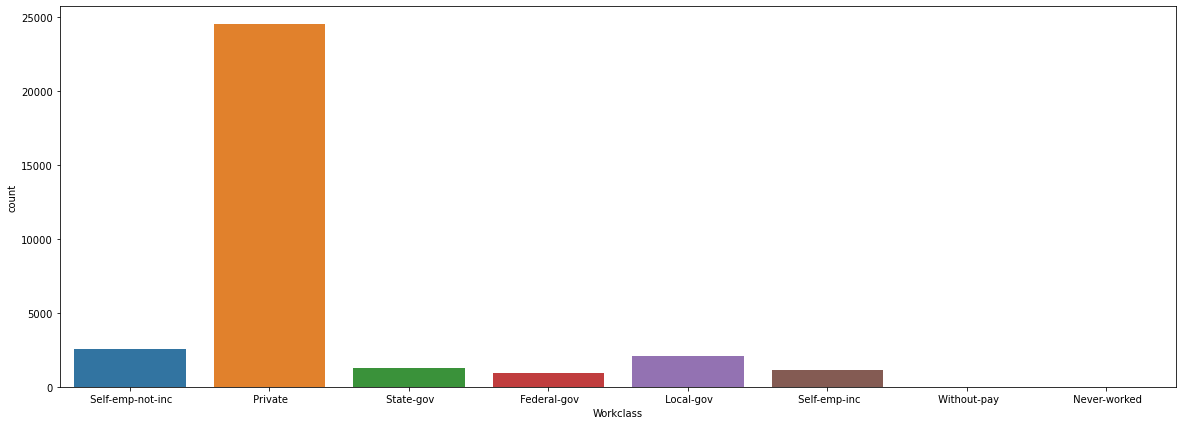

In [34]:
#Count Plot for "Workclass" column
print(census["Workclass"].value_counts())

plt.figure(figsize=(20,7))
sns.countplot("Workclass",data=census)

We can observe most population works in Private sector (total=24532) and least population (total=7) have Never-worked

 HS-grad         10501
 Some-college     7291
 Bachelors        5354
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: Education, dtype: int64


<AxesSubplot:xlabel='Education', ylabel='count'>

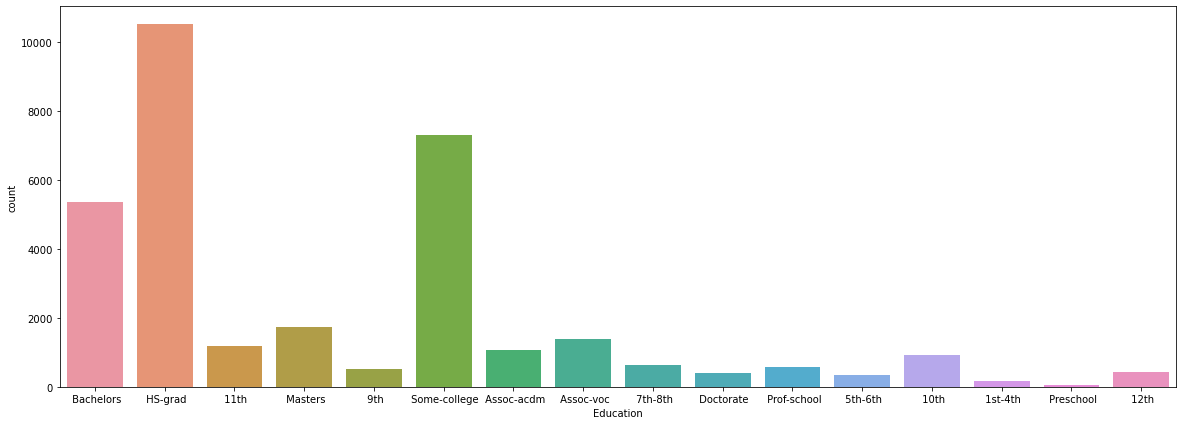

In [35]:
#Count Plot for "Education" column
print(census["Education"].value_counts())

plt.figure(figsize=(20,7))
sns.countplot("Education",data=census)

We can observe most population passed HS-grad (total=10501) and least population (total=51) passed Preschool

 Married-civ-spouse       14976
 Never-married            10682
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Marital_status, dtype: int64


<AxesSubplot:xlabel='Marital_status', ylabel='count'>

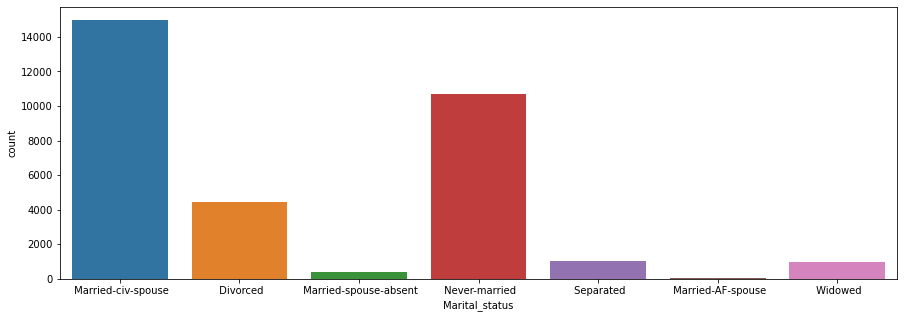

In [36]:
#Count Plot for "Marital_status" column
print(census["Marital_status"].value_counts())

plt.figure(figsize=(15,5))
sns.countplot("Marital_status",data=census)


We can observe most population are Married-civ-spouse (total=14976) and least population (total=23) are Married-AF-spouse.

 Prof-specialty       5983
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3769
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64


<AxesSubplot:xlabel='Occupation', ylabel='count'>

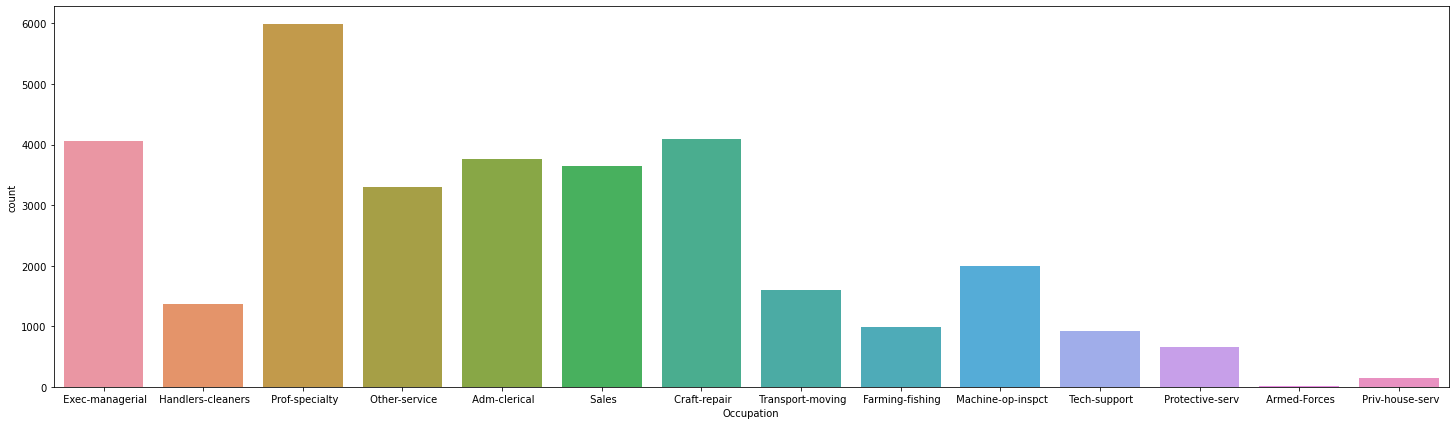

In [37]:
#Count Plot for "Occupation" column
print(census["Occupation"].value_counts())
plt.figure(figsize=(25,7))
sns.countplot("Occupation",data=census)

We can observe most population are Married-civ-spouse (total=14976) and least population (total=23) are Married-AF-spouse.

 Husband           13193
 Not-in-family      8304
 Own-child          5068
 Unmarried          3446
 Wife               1568
 Other-relative      981
Name: Relationship, dtype: int64


<AxesSubplot:xlabel='Relationship', ylabel='count'>

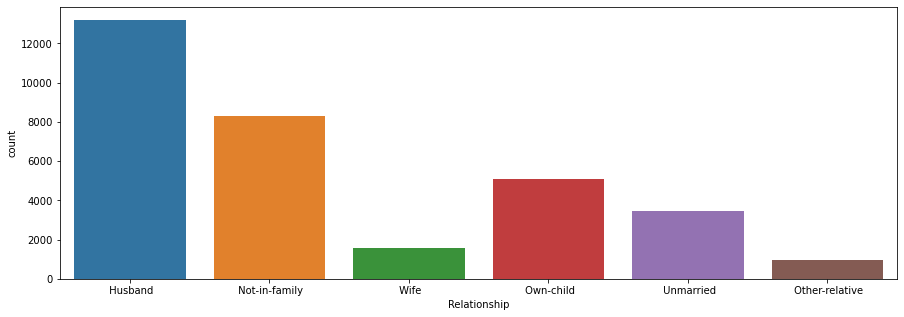

In [38]:
#Count Plot for "Relationship" column
print(census["Relationship"].value_counts())

plt.figure(figsize=(15,5))
sns.countplot("Relationship",data=census)

We can observe Husband are more in population (total=13193) and Other-relative are least in population (total=981).

 White                 27815
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: Race, dtype: int64


<AxesSubplot:xlabel='Race', ylabel='count'>

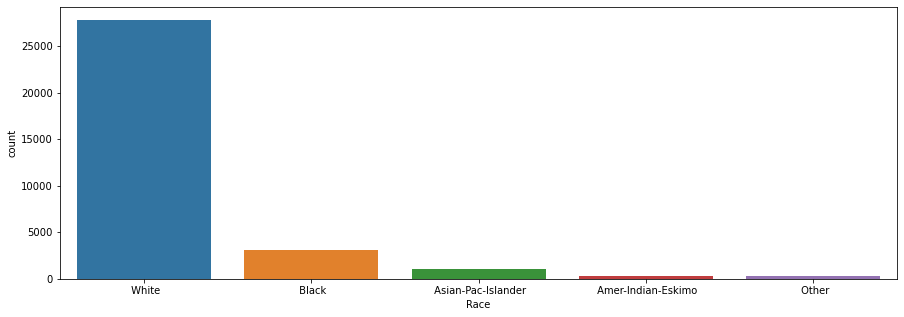

In [39]:
#Count Plot for "Race" column
print(census["Race"].value_counts())

plt.figure(figsize=(15,5))
sns.countplot("Race",data=census)

We can observe most population are of the race White (total=27815) and least population (total=271) are of the race Other.

 Male      21789
 Female    10771
Name: Sex, dtype: int64


<AxesSubplot:xlabel='Sex', ylabel='count'>

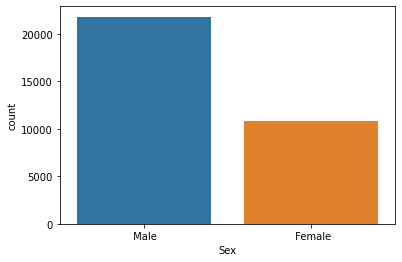

In [40]:
#Count Plot for "Sex" column
print(census["Sex"].value_counts())

sns.countplot("Sex",data=census)

We can observe most population are Male (total=21789) and least population (total=10771) are Female.

 United-States                 29752
 Mexico                          643
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 France                           29
 

<AxesSubplot:xlabel='Native_country', ylabel='count'>

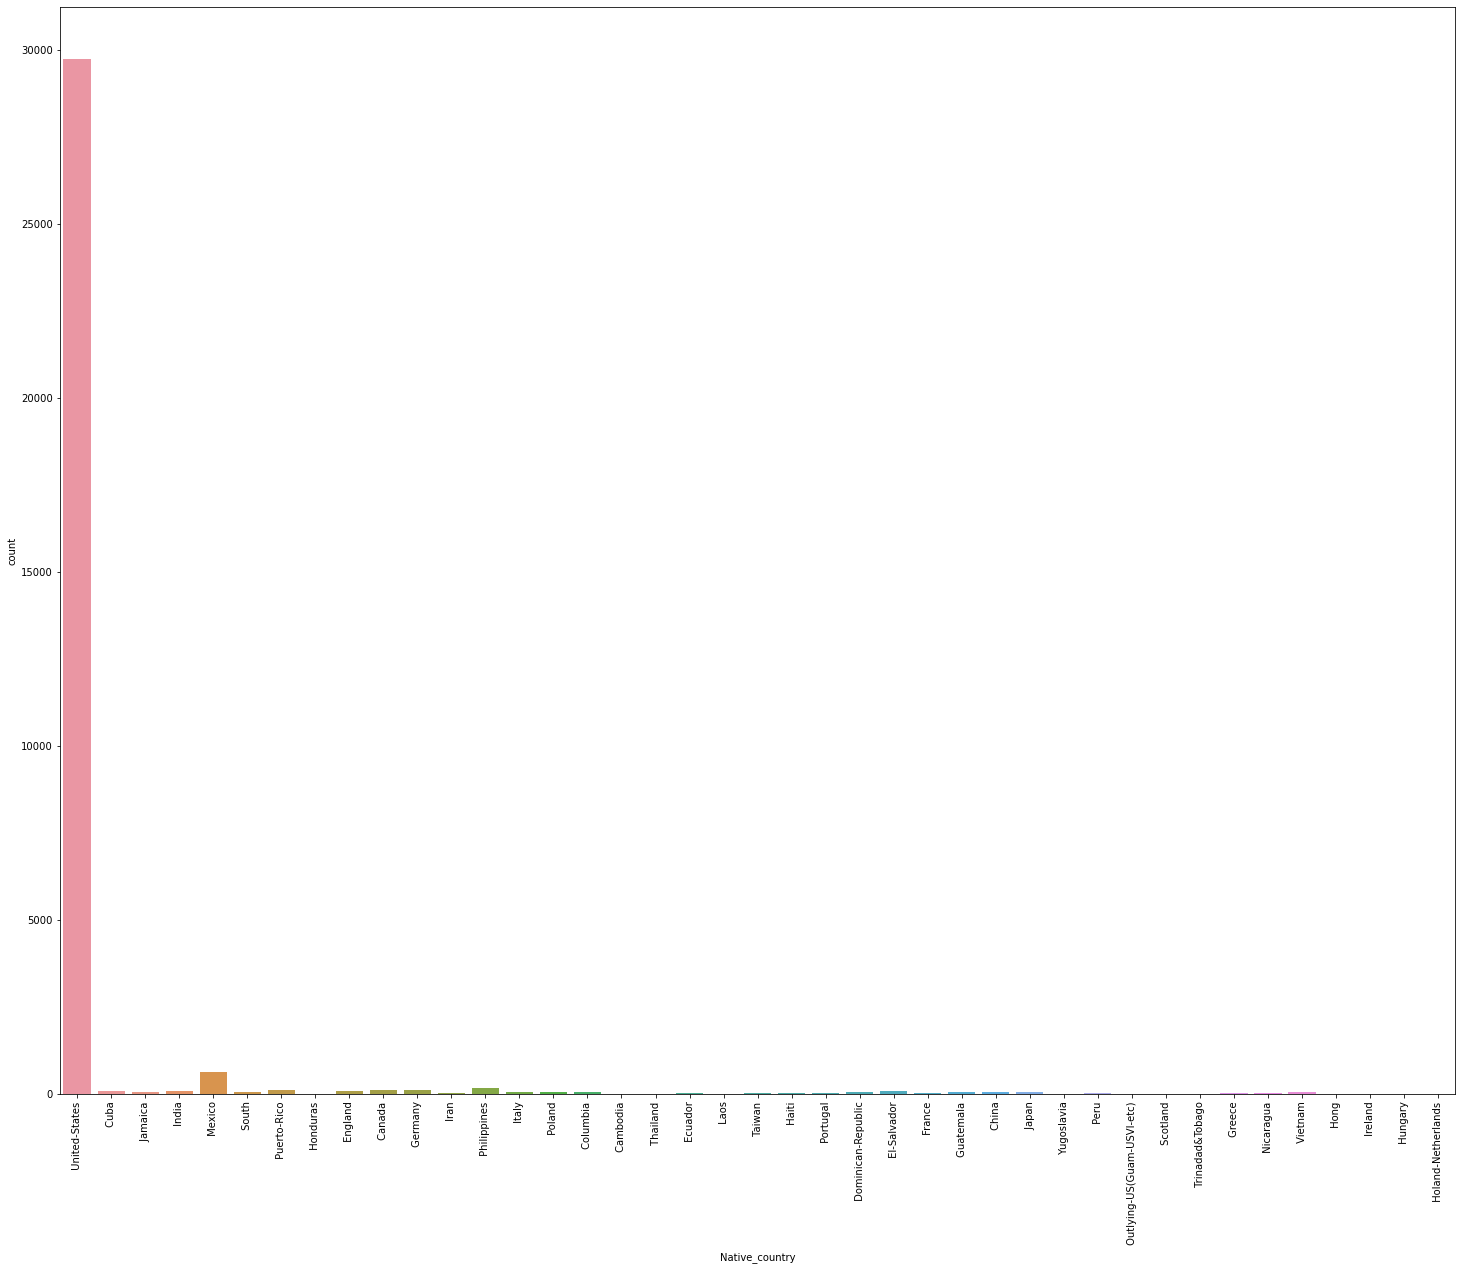

In [41]:
#Count Plot for "Native_country" column
print(census["Native_country"].value_counts())
plt.figure(figsize=(25,20))
plt.xticks(rotation=90)
sns.countplot(x="Native_country",data=census)

We can observe most population are from United-States (total=29752) and least population (total=1) are from Holand-Netherlands .

 <=50K    24719
 >50K      7841
Name: Income, dtype: int64


<AxesSubplot:xlabel='Income', ylabel='count'>

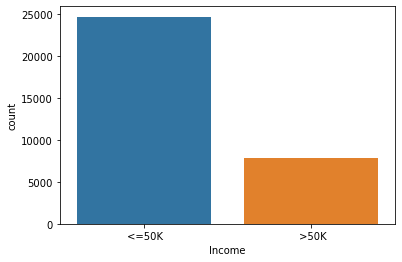

In [42]:
#Count Plot for "Income" column
print(census["Income"].value_counts())

sns.countplot("Income",data=census)

We can observe most population having <=50K income (total=24719) and least population (total=7841) having >50K income.

### Using Histplot for continuous columns

36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: Age, Length: 73, dtype: int64


<AxesSubplot:xlabel='Age', ylabel='Count'>

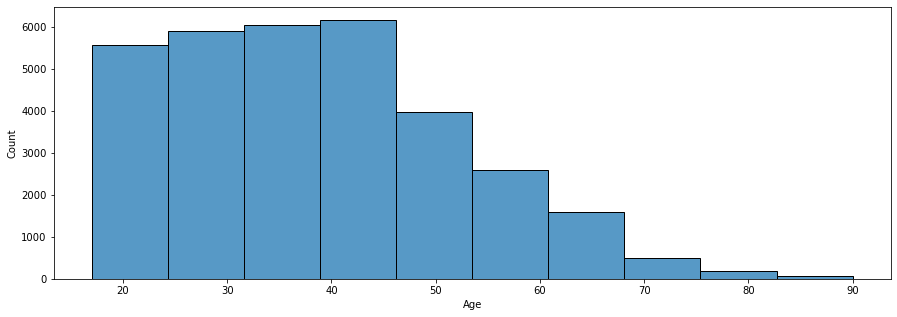

In [43]:
#Histplot for "Age" column
print(census["Age"].value_counts())
plt.figure(figsize=(15,5))
sns.histplot(x='Age',data=census,bins=10)

We can observe most population are of the Age of 36.

164190    13
203488    13
123011    13
148995    12
126675    12
          ..
325573     1
140176     1
318264     1
329205     1
257302     1
Name: Fnlwgt, Length: 21647, dtype: int64


<AxesSubplot:xlabel='Fnlwgt', ylabel='Count'>

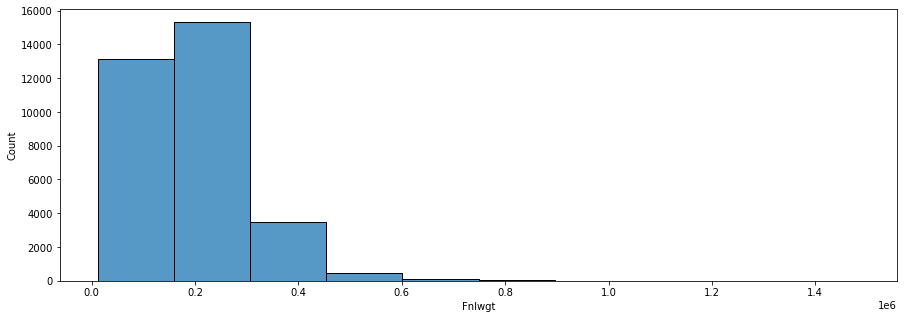

In [44]:
#Histplot for "Fnlwgt" column
print(census["Fnlwgt"].value_counts())
plt.figure(figsize=(15,5))
sns.histplot(x='Fnlwgt',data=census,bins=10)

We can observe most population are of the Fnlwgt (weight) of 164190 is more.

9     10501
10     7291
13     5354
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: Education_num, dtype: int64


<AxesSubplot:xlabel='Education_num', ylabel='Count'>

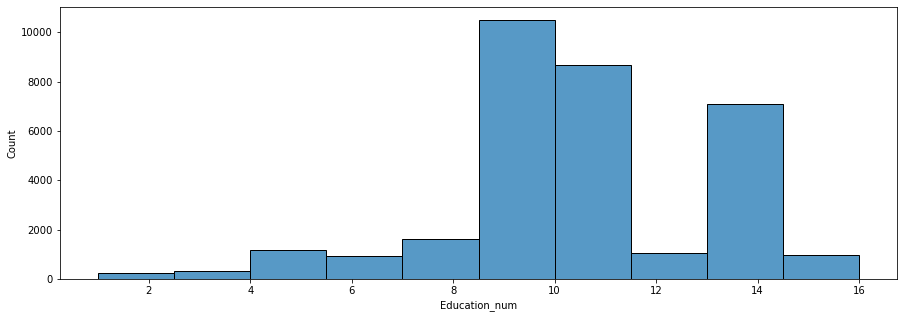

In [45]:
#Histplot for "Education_num" column
print(census["Education_num"].value_counts())
plt.figure(figsize=(15,5))
sns.histplot(x='Education_num',data=census,bins=10)

We can observe most population are of the Education_num of 9 is more.

0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
1111         1
2538         1
22040        1
4931         1
5060         1
Name: Capital_gain, Length: 119, dtype: int64


<AxesSubplot:xlabel='Capital_gain', ylabel='Count'>

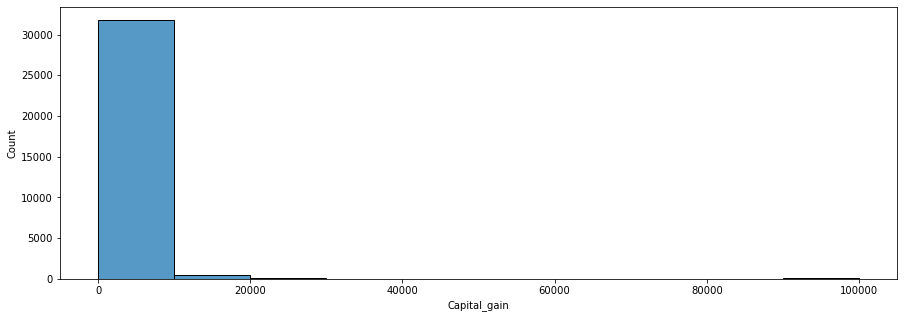

In [46]:
#Histplot for "Capital_gain" column
print(census["Capital_gain"].value_counts())
plt.figure(figsize=(15,5))
sns.histplot(x='Capital_gain',data=census,bins=10)

We can observe most population having capital_gain of 0 is more. So, we will drop this column as it contains 0 value more.

0       31041
1902      202
1977      168
1887      159
1848       51
        ...  
2080        1
1539        1
1844        1
2489        1
1411        1
Name: Capital_loss, Length: 92, dtype: int64


<AxesSubplot:xlabel='Capital_loss', ylabel='Count'>

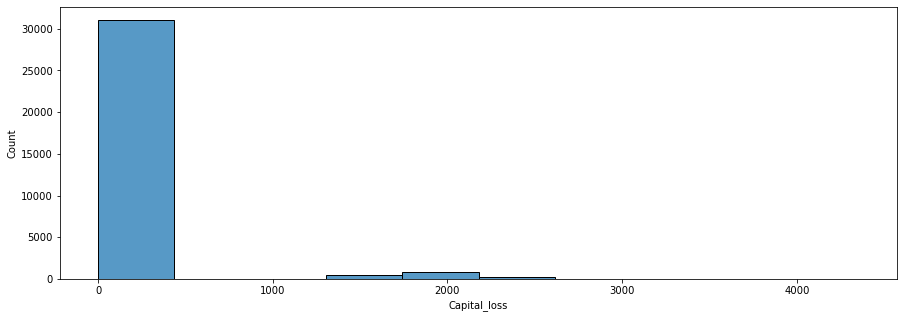

In [47]:
#Histplot for "Capital_loss" column
print(census["Capital_loss"].value_counts())
plt.figure(figsize=(15,5))
sns.histplot(x='Capital_loss',data=census,bins=10)

We can observe most population having capital_loss of 0 is more. So, we will drop this column as it contains 0 value more.

40    15216
50     2819
45     1824
60     1475
35     1297
      ...  
82        1
94        1
92        1
74        1
87        1
Name: Hours_per_week, Length: 94, dtype: int64


<AxesSubplot:xlabel='Hours_per_week', ylabel='Count'>

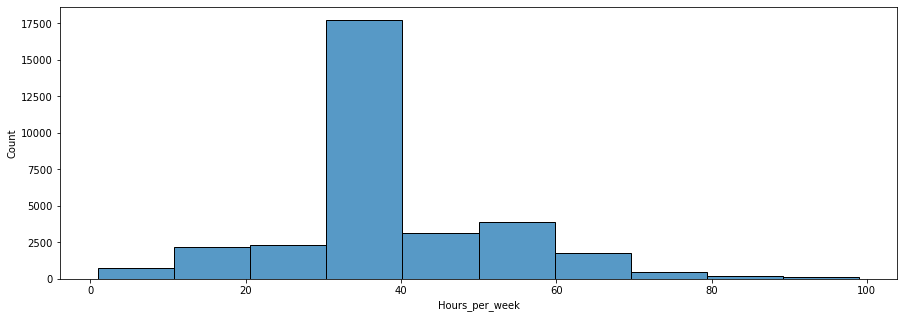

In [48]:
#Histplot for "Hours_per_week" column
print(census["Hours_per_week"].value_counts())
plt.figure(figsize=(15,5))
sns.histplot(x='Hours_per_week',data=census,bins=10)

We can observe most population's Hours_per_week' 40 is more.

### Bivariate Analysis

<AxesSubplot:xlabel='Workclass', ylabel='count'>

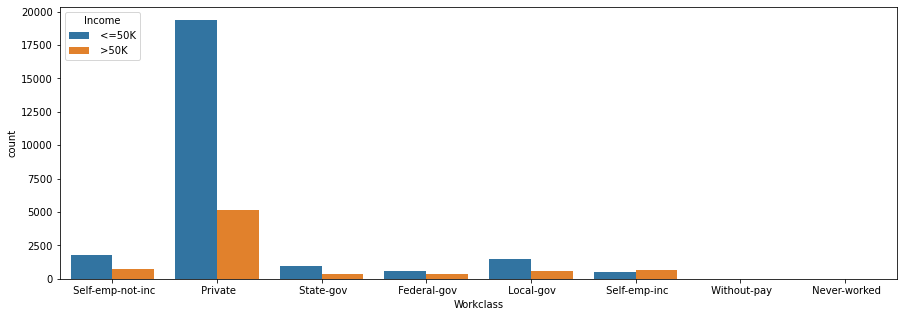

In [49]:
#Count Plot for comparision between "Workclass" column and "Income" column
plt.figure(figsize=(15,5))
sns.countplot("Workclass",data=census, hue='Income')

The most of the population works in the private sector have income <= 50k

<AxesSubplot:xlabel='Education', ylabel='count'>

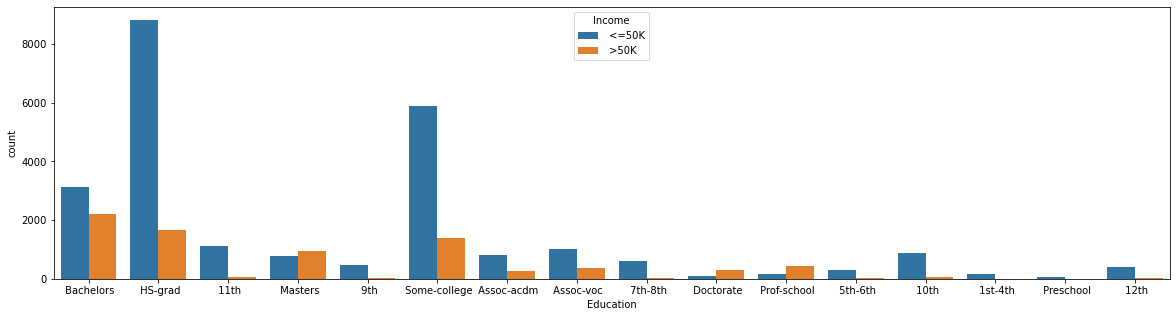

In [50]:
#Count Plot for comparision between "Education" column and "Income" column
plt.figure(figsize=(20,5))
sns.countplot("Education",data=census, hue='Income')

The most of the population having HS-grad having income <= 50k compare >50K

<AxesSubplot:xlabel='Marital_status', ylabel='count'>

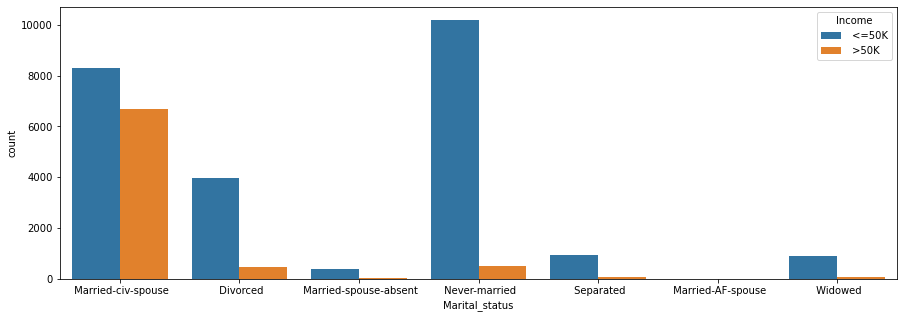

In [51]:
#Count Plot for comparision between "Marital_status" column and "Income" column
plt.figure(figsize=(15,5))
sns.countplot("Marital_status",data=census, hue='Income')

The most of the population having Marital_status "Never-married" have mostly income <=50K and having income >50K is less.

<AxesSubplot:xlabel='Occupation', ylabel='count'>

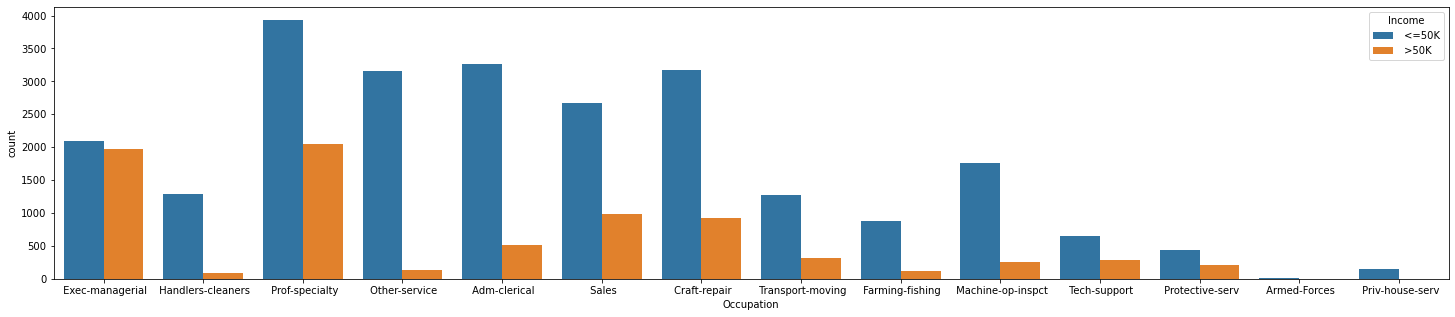

In [52]:
#Count Plot for comparision between "Occupation" column and "Income" column
plt.figure(figsize=(25,5))
sns.countplot("Occupation",data=census, hue='Income')

Having occupation Prof-Speciality is having mostly income <=50K

<AxesSubplot:xlabel='Relationship', ylabel='count'>

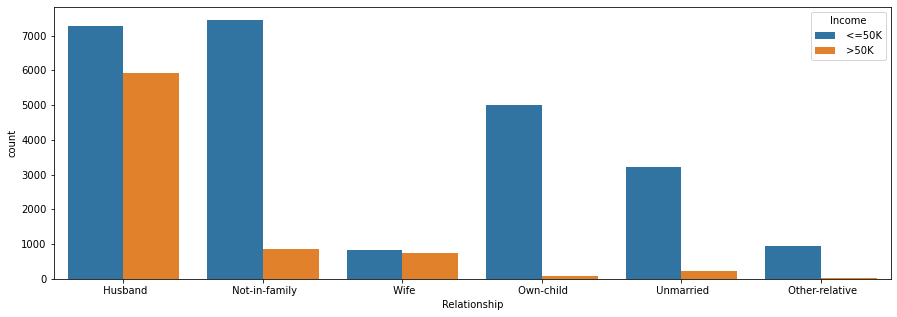

In [53]:
#Count Plot for comparision between "Relationship" column and "Income" column
plt.figure(figsize=(15,5))
sns.countplot("Relationship",data=census, hue='Income')

Income <=50K is more in Not-in-family Relationship

<AxesSubplot:xlabel='Race', ylabel='count'>

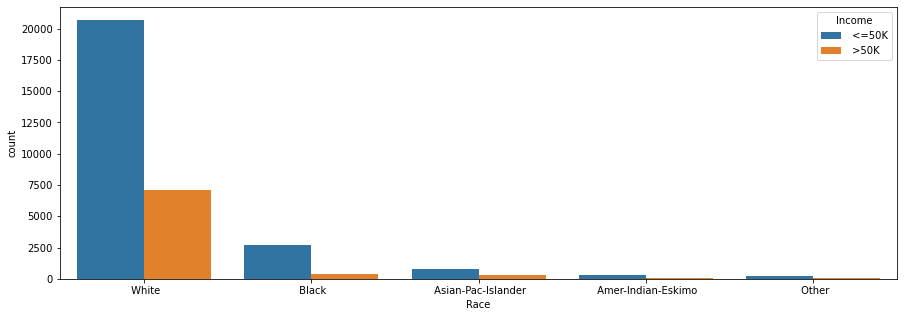

In [54]:
#Count Plot for comparision between "Race" column and "Income" column
plt.figure(figsize=(15,5))
sns.countplot("Race",data=census, hue='Income')

Population having race of "White" is having mostly income<=50K

<AxesSubplot:xlabel='Sex', ylabel='count'>

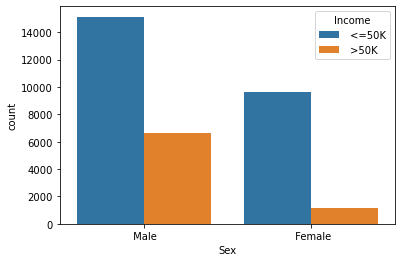

In [55]:
#Count Plot for comparision between "Sex" column and "Income" column
sns.countplot("Sex",data=census, hue='Income')

Mostly male population are having income <=50K compare to female.

<AxesSubplot:xlabel='Native_country', ylabel='count'>

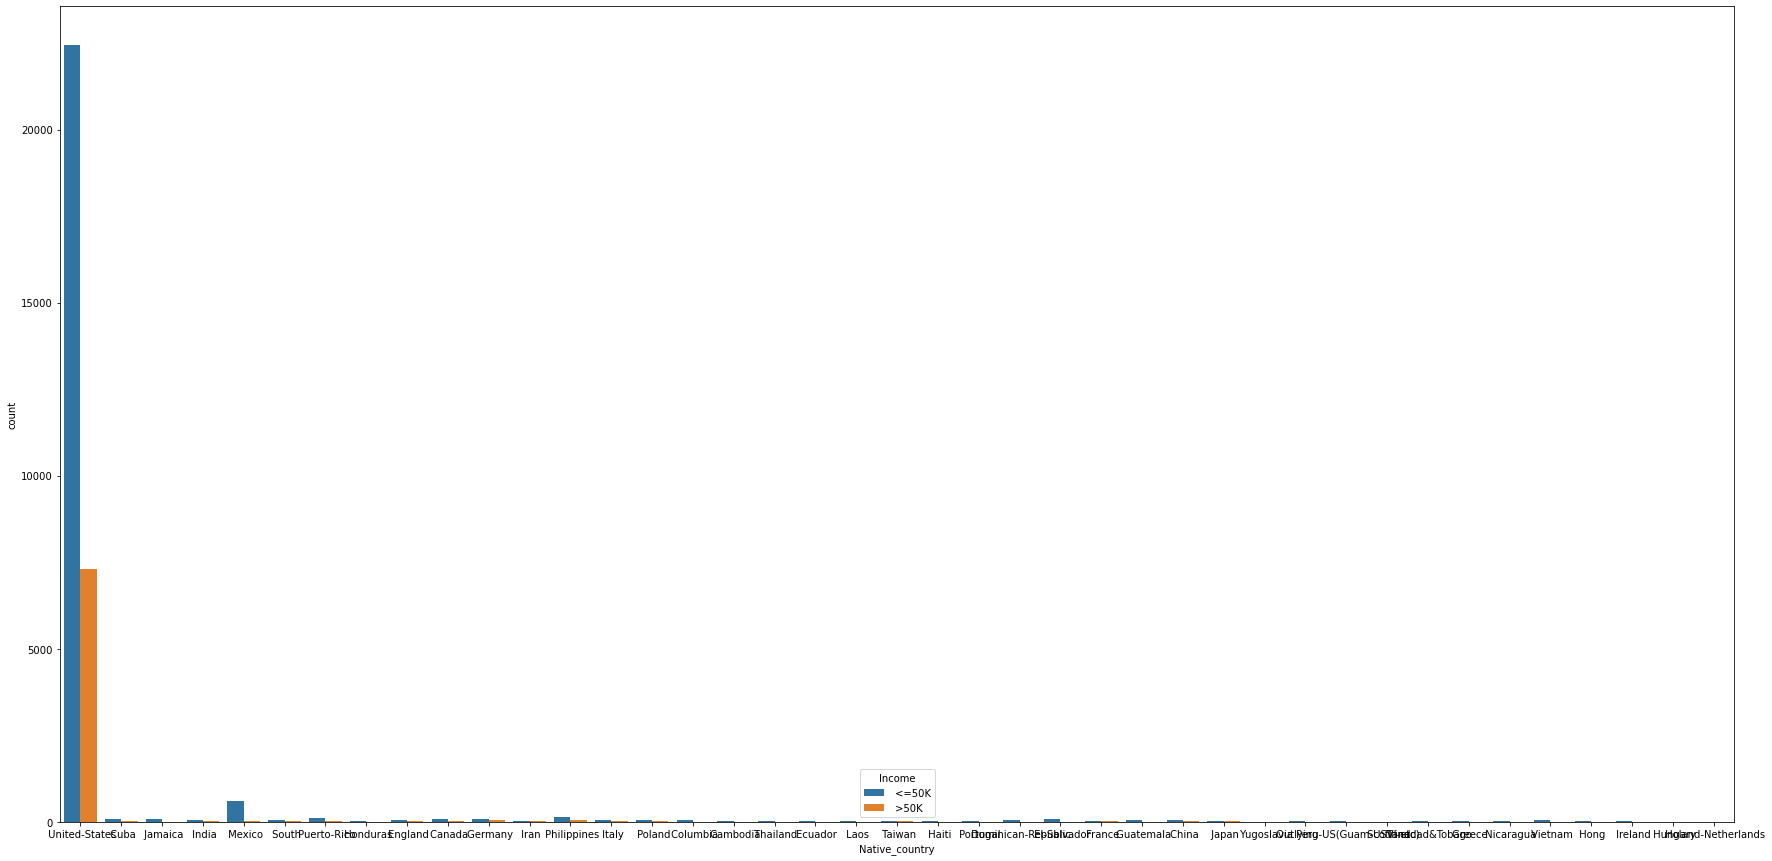

In [56]:
#Count Plot for comparision between "Native_country" column and "Income" column
plt.figure(figsize=(30,15))
sns.countplot("Native_country",data=census, hue='Income')

Income <= 50K is high of country United States compare to other states and Income >50K is also high of United States compare to other states.

<AxesSubplot:xlabel='Income', ylabel='Age'>

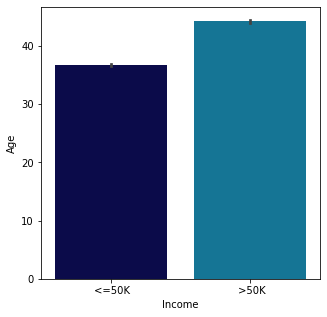

In [57]:
#Bar Plot for comparision between "Age" and "Income" column
plt.figure(figsize=(5,5))
sns.barplot(y='Age', x='Income',data=census, palette='ocean')

Population having age more than 45+ are having income >50K more compare to <=50K.

<AxesSubplot:xlabel='Income', ylabel='Fnlwgt'>

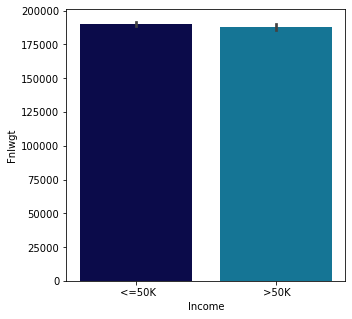

In [58]:
#Bar Plot for comparision between "Fnlwgt" and "Income" column
plt.figure(figsize=(5,5))
sns.barplot(y='Fnlwgt', x='Income',data=census, palette='ocean')

Fnlwgt of population are equal for both Income ( <=50K and >50K ).

<AxesSubplot:xlabel='Income', ylabel='Education_num'>

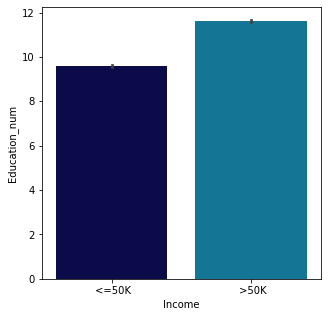

In [59]:
#Bar Plot for comparision between "Education_num" and "Income" column
plt.figure(figsize=(5,5))
sns.barplot(y='Education_num', x='Income',data=census, palette='ocean')

Income >50K is more of Education_num compare to Income <=50K of Population

<AxesSubplot:xlabel='Income', ylabel='Capital_gain'>

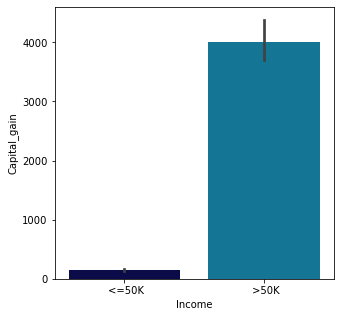

In [60]:
#Bar Plot for comparision between "Capital_gain" and "Income" column
plt.figure(figsize=(5,5))
sns.barplot(y='Capital_gain', x='Income',data=census, palette='ocean')

Income >50K is highest Capital_gain compare to <=50K of population.

<AxesSubplot:xlabel='Income', ylabel='Capital_loss'>

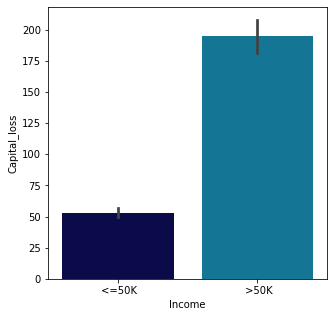

In [61]:
#Bar Plot for comparision between "Capital_loss" and "Income" column
plt.figure(figsize=(5,5))
sns.barplot(y='Capital_loss', x='Income',data=census, palette='ocean')

Income >50K is highest Capital_loss too compare to <=50K of population.

<AxesSubplot:xlabel='Income', ylabel='Hours_per_week'>

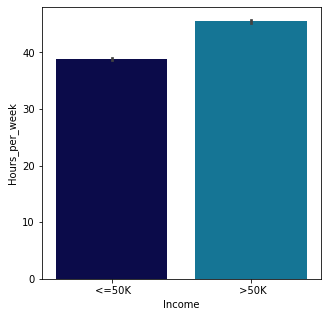

In [62]:
#Bar Plot for comparision between "Hours_per_week" and "Income" column
plt.figure(figsize=(5,5))
sns.barplot(y='Hours_per_week', x='Income',data=census, palette='ocean')

Income >50K is having more Hours_per_week.

## Multivariate Analysis

#### Using Pairplot

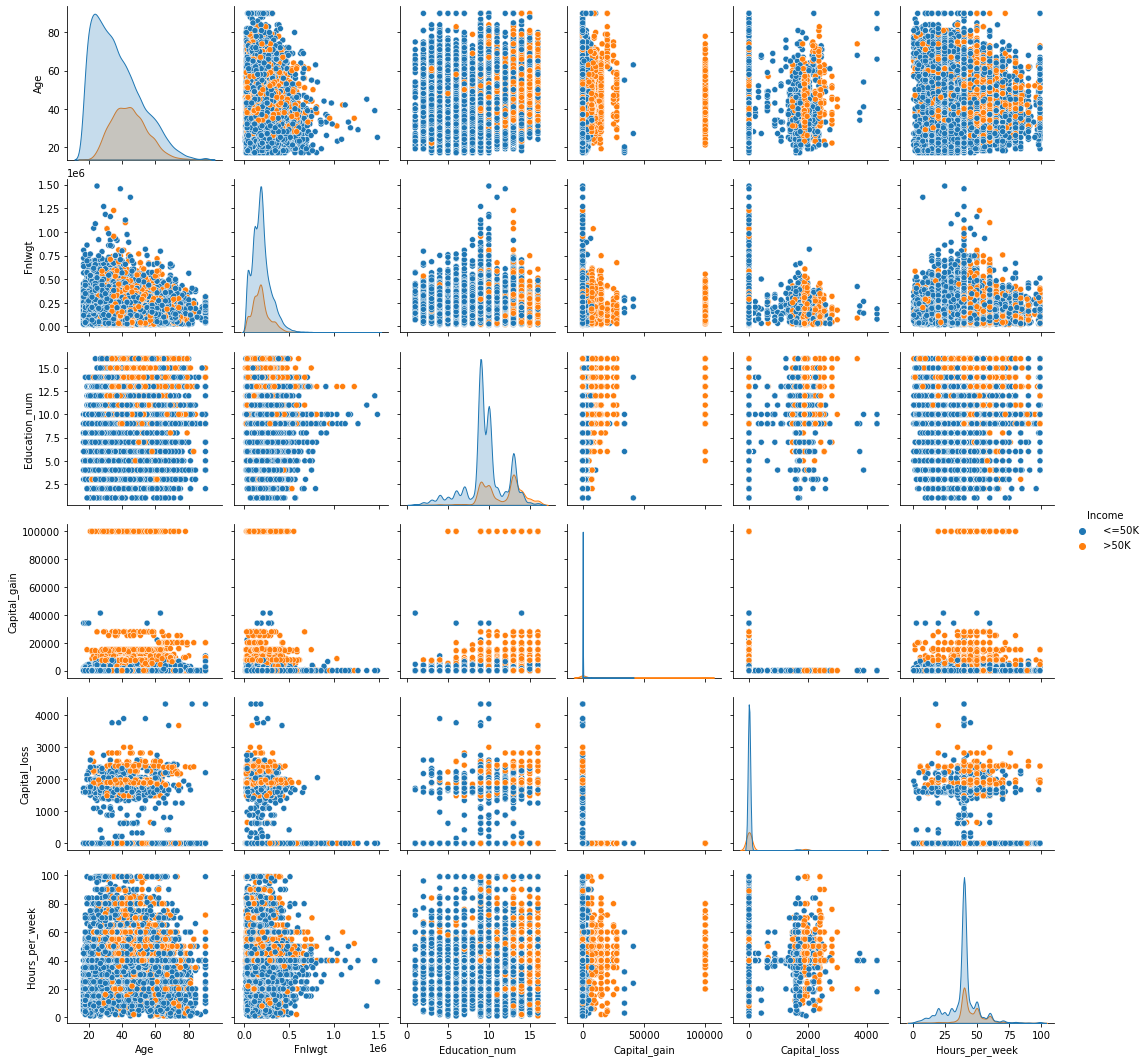

In [63]:
sns.pairplot(census,hue="Income")

We can observe relationship between all the featues column and the target column by this pairplot in pairs which are plotted on basis of target column.

#### Dropping irrelevant column

In [64]:
census.drop(columns = "Capital_gain", inplace = True)
census.drop(columns = "Capital_loss", inplace = True)

In [65]:
census.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Hours_per_week', 'Native_country', 'Income'],
      dtype='object')

In [66]:
census.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States,<=50K


## Label Encoding

In [67]:
from sklearn.preprocessing import LabelEncoder

In [68]:
encoder=LabelEncoder()

In [69]:
census['Workclass'] = encoder.fit_transform(census['Workclass'])
census['Education'] = encoder.fit_transform(census['Education'])
census['Marital_status'] = encoder.fit_transform(census['Marital_status'])
census['Occupation'] = encoder.fit_transform(census['Occupation'])
census['Relationship'] = encoder.fit_transform(census['Relationship'])
census['Race'] = encoder.fit_transform(census['Race'])
census['Sex'] = encoder.fit_transform(census['Sex'])
census['Native_country'] = encoder.fit_transform(census['Native_country'])
census['Income'] = encoder.fit_transform(census['Income'])

## Checking Correlation

In [70]:
census.corr()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Hours_per_week,Native_country,Income
Age,1.000000,0.040506,-0.076646,-0.010508,0.036527,-0.266292,0.001740,-0.263698,0.028718,0.088832,0.068756,-0.000271,0.234039
Workclass,0.040506,1.000000,-0.024255,0.004901,0.003445,-0.020545,0.007236,-0.057931,0.048323,0.071535,0.042206,-0.001646,0.002739
Fnlwgt,-0.076646,-0.024255,1.000000,-0.028156,-0.043159,0.028184,0.000138,0.008922,-0.021278,0.026882,-0.018770,-0.063279,-0.009481
Education,-0.010508,0.004901,-0.028156,1.000000,0.359172,-0.038398,-0.041297,-0.010879,0.014135,-0.027349,0.055510,0.076062,0.079311
Education_num,0.036527,0.003445,-0.043159,0.359172,1.000000,-0.069338,0.071012,-0.094145,0.031825,0.012256,0.148127,0.088887,0.335182
Marital_status,-0.266292,-0.020545,0.028184,-0.038398,-0.069338,1.000000,0.035008,0.185461,-0.068025,-0.129337,-0.190521,-0.021285,-0.199295
Occupation,0.001740,0.007236,0.000138,-0.041297,0.071012,0.035008,1.000000,-0.037465,-0.004821,0.047497,-0.012881,-0.002205,0.034599
Relationship,-0.263698,-0.057931,0.008922,-0.010879,-0.094145,0.185461,-0.037465,1.000000,-0.116052,-0.582453,-0.248975,-0.010710,-0.250924
Race,0.028718,0.048323,-0.021278,0.014135,0.031825,-0.068025,-0.004821,-0.116052,1.000000,0.087197,0.041910,0.116526,0.071853
Sex,0.088832,0.071535,0.026882,-0.027349,0.012256,-0.129337,0.047497,-0.582453,0.087197,1.000000,0.229312,0.002055,0.215995


This gives the correlation between the denpendent and independent variables.

In [71]:
census.corr()["Income"].sort_values()

Relationship     -0.250924
Marital_status   -0.199295
Fnlwgt           -0.009481
Workclass         0.002739
Native_country    0.023063
Occupation        0.034599
Race              0.071853
Education         0.079311
Sex               0.215995
Hours_per_week    0.229690
Age               0.234039
Education_num     0.335182
Income            1.000000
Name: Income, dtype: float64

**We can observe :**

* All columns are sorted in ascending order showing least to strong correlation with target column.
* 3 columns are negatively correlated and 9 columns are positively correlated.
* Column 'Education_num' is highly correlated with Target column and Column 'Relationship' is least correlated with Target column

## Checking correlation with heatmap

<AxesSubplot:>

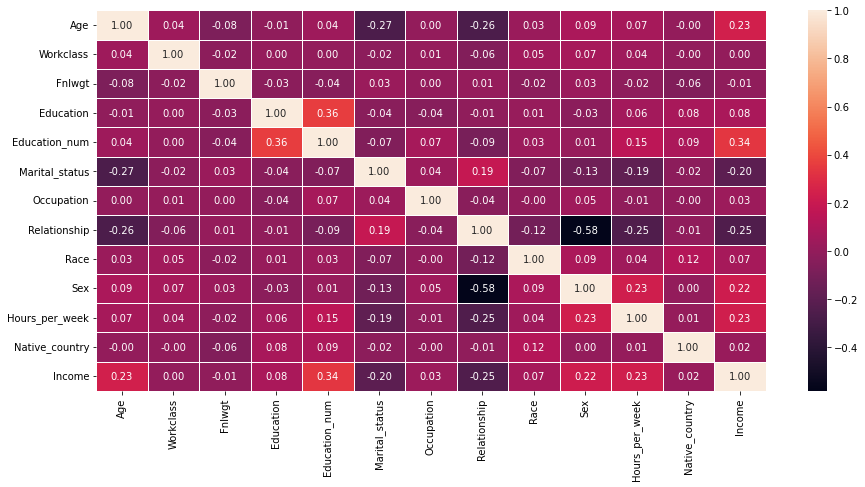

In [72]:
plt.figure(figsize=(15,7))
sns.heatmap(census.corr(),annot=True, linewidth=0.5, linecolor='white', fmt='.2f')

## Outcome of Correlation
* Age has 23 percent correlation with the target column which can be considered as good correlation and positively correlated.
* Workclass has 0 percent correlation with the target column which can be considered as good correlation and positively correlated.
* Fnlwgt has -1 percent correlation with the target column which can be considered as good correlation and negatively correlated.
* Education has 8 percent correlation with the target column which can be considered as good correlation and positively correlated.
* Education_num has 34 percent correlation with the target column which can be considered as strong correlation and positively correlated.
* Marital_status has -20 percent correlation with the target column which can be considered as good correlation and negatively correlated.
* Occupation has 3 percent correlation with the target column which can be considered as good correlation and positively correlated.
* Relationship has -25 percent correlation with the target column which can be considered as weak correlation and negatively correlated.
* Race has 7 percent correlation with the target column which can be considered as good correlation and positively correlated.
* Sex has 22 percent correlation with the target column which can be considered as strong correlation and positively correlated.
* Hours_per_week has 23 percent correlation with the target column which can be considered as good correlation and positively correlated.
* Native_country has 2 percent correlation with the target column which can be considered as good correlation and positively correlated.


* Max correlation is with Education_num
* Min correlation is with Relationship

## Checking correlation with barplot

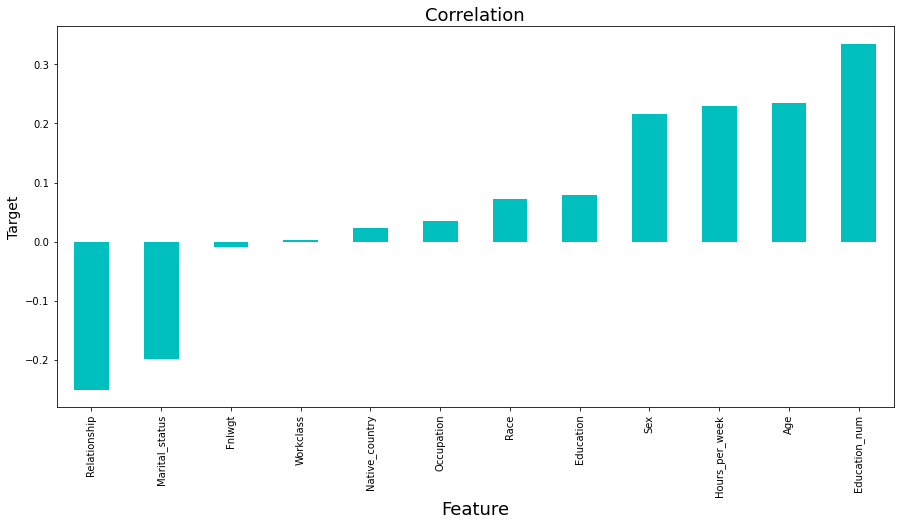

In [73]:
plt.figure(figsize=(15,7))
census.corr()['Income'].sort_values(ascending=True).drop(['Income']).plot(kind='bar',color='c')
plt.xlabel('Feature',fontsize=18)
plt.ylabel('Target',fontsize=14)
plt.title('Correlation',fontsize=18)
plt.show()

**Outcome:**
* Here we can see Workclass is least but positively correletaed with Target Column and Relationship is highly but negatively correletaed with Target Column.
* So, Least correlated is Relationship and Highly correlated is Education_num with target column.

In [74]:
census.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Hours_per_week', 'Native_country', 'Income'],
      dtype='object')

## Checking Outliers

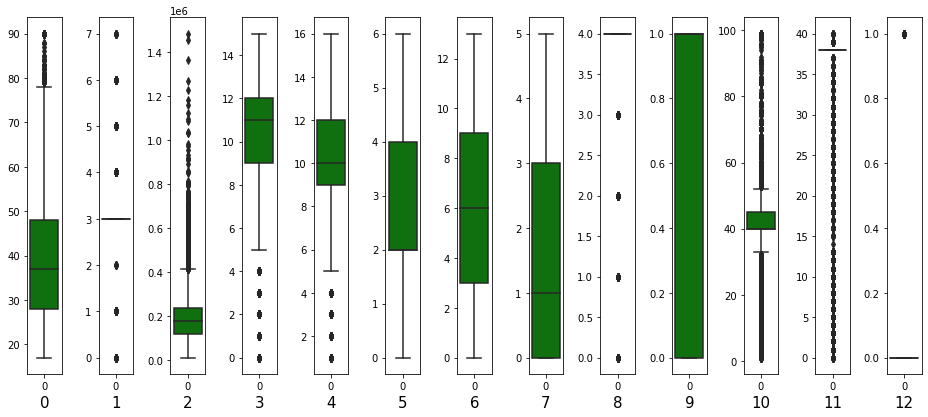

In [75]:
collist=census.columns.values
ncol=13
nrows=7
plt.figure(figsize=(ncol,3*ncol))
for column in range(0,len(collist)):
    plt.subplot(nrows,ncol,column+1)
    sns.boxplot(data=census[collist[column]],color='green',orient='v')
    plt.xlabel(column,fontsize = 15)
    plt.tight_layout()

### Observation:
* Outliers present in columns: 'Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num', 'Race', 'Hours_per_week', 'Native_country', 'Income'.

* Outliers not present in columns: 'Marital_status', 'Occupation', 'Relationship', 'Sex'.

# Removing Outliers

## 1. Zscore method using Scipy

In [76]:
#  Outliers will be removed only from Continuous column variable i.e; 'Age', 'Fnlwgt', 'Education_num' and 'Hours_per_week'. 
#We will not remove outliers from Categorical column i.e;  'Workclass', 'Education', 'Race' , 'Native_country' and 'Income'.

variables = census[['Age', 'Fnlwgt', 'Education_num', 'Hours_per_week']]
z=np.abs(zscore(variables))

# Creating new dataframe
census_income = census[(z<3).all(axis=1)]
census_income.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Hours_per_week,Native_country,Income
0,50,5,83311,9,13,2,3,0,4,1,13,38,0
1,38,3,215646,11,9,0,5,1,4,1,40,38,0
2,53,3,234721,1,7,2,5,0,2,1,40,38,0
3,28,3,338409,9,13,2,9,5,2,0,40,4,0
4,37,3,284582,12,14,2,3,5,4,0,40,38,0


In [77]:
z.head()

,Age,Fnlwgt,Education_num,Hours_per_week
0,0.837097,1.008742,1.134779,2.22212
1,0.042640,0.245046,0.420027,0.03543
2,1.057031,0.425770,1.197429,0.03543
3,0.775755,1.408146,1.134779,0.03543
4,0.115952,0.898170,1.523480,0.03543


In [78]:
print("Old DataFrame data in Rows and Column:",census.shape)
print("New DataFrame data in Rows and Column:",census_income.shape)
print("Total Dropped rows:",census.shape[0]-census_income.shape[0])

Old DataFrame data in Rows and Column: (32560, 13)
New DataFrame data in Rows and Column: (31461, 13)
Total Dropped rows: 1099


## Percentage Data Loss using Zscore

In [79]:
loss_percent=(32560-31461)/32560*100
print(loss_percent,"%")

3.3753071253071254 %


### 2. IQR (Inter Quantile Range) method

In [80]:
#1st quantile
Q1=variables.quantile(0.25)

# 3rd quantile
Q3=variables.quantile(0.75)

#IQR
IQR=Q3 - Q1
census_I=census[~((census < (Q1 - 1.5 * IQR)) |(census > (Q3 + 1.5 * IQR))).any(axis=1)]

In [81]:
print("Old DataFrame data in Rows and Column:",census.shape)
print("\nNew DataFrame data in Rows and Column:",census_I.shape)
print("\nTotal Dropped rows:",census.shape[0]-census_I.shape[0])

Old DataFrame data in Rows and Column: (32560, 13)

New DataFrame data in Rows and Column: (21950, 13)

Total Dropped rows: 10610


### Percentage Data Loss using IQR

In [82]:
loss_perc = (32560-21950)/32560*100
loss_perc

32.58599508599509

We can check by using IQR method there is large data loss in comparision to Zscore method. So, we will consider Zscore method.

### Checking for the skewness

In [83]:
census_income.skew()

Age               0.472279
Workclass         0.077358
Fnlwgt            0.634828
Education        -0.949556
Education_num    -0.159752
Marital_status   -0.025162
Occupation        0.003278
Relationship      0.777721
Race             -2.453934
Sex              -0.708658
Hours_per_week   -0.341724
Native_country   -4.362026
Income            1.205962
dtype: float64

## Observation:
* Skewness threshold taken is +/-0.25
* Columns which are having skewness: Age, Fnlwgt, Education, Relationship, Race, Sex, Hours_per_week, Native_country and Income.
* The Native_country column data is negatively highly skewed and Relationship is positively highly skewed
* All the columns are not normallly distributed, they are skewed.
* Since Education, Relationship, Race, Sex and Native_country are categorical column so we will not remove skewness from them and Income is Target Column so we will not remove skewness.
* Only we will remove skewness from Fnlwgt as this column contains continuous data.

### Checking skweness through Data Visualization

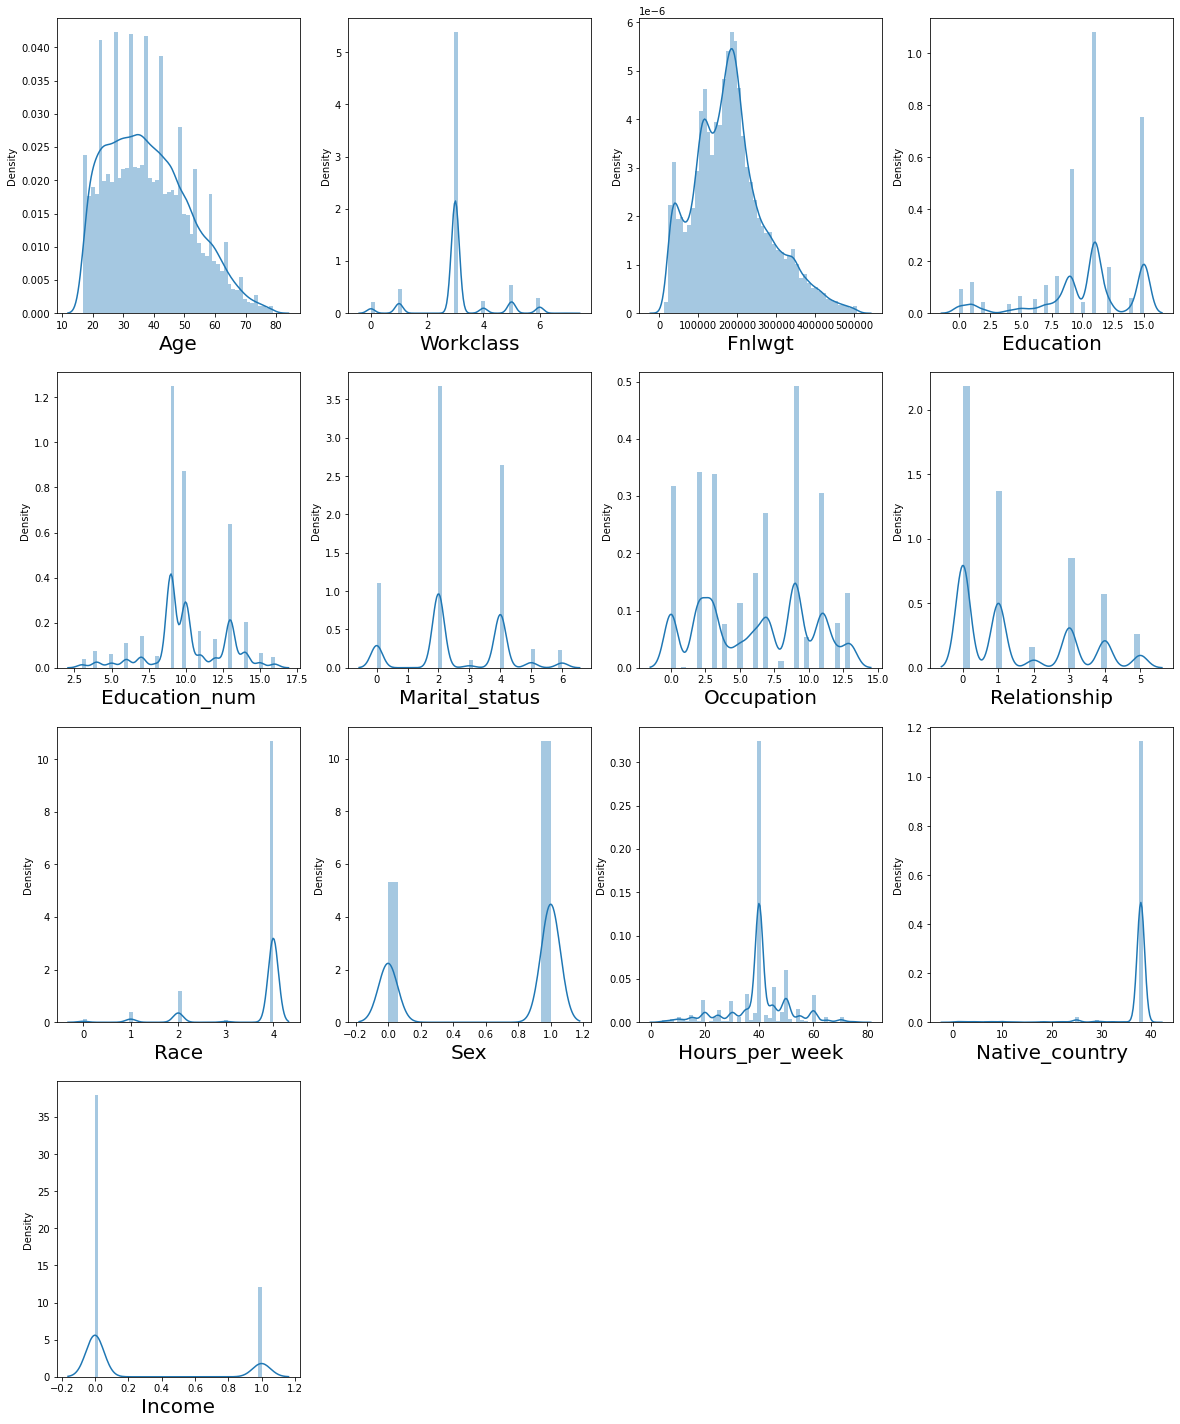

In [84]:
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in census_income:
    if plotnumber<=13:
        ax = plt.subplot(4,4,plotnumber)
        sns.distplot(census_income[column])
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.show()

### Data visualization of skewed continuous column using distplot

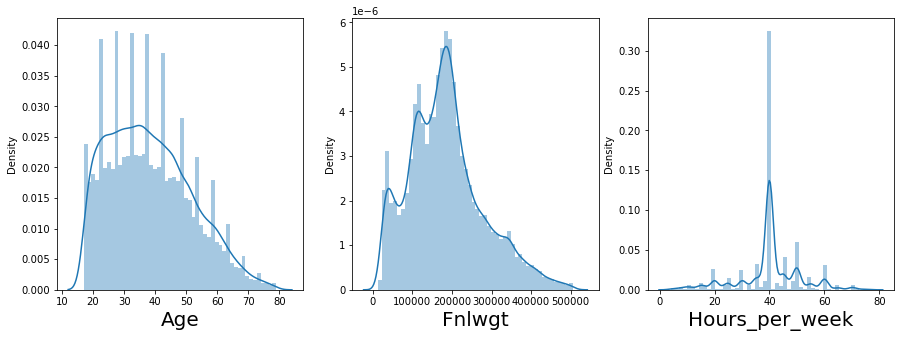

In [85]:
collist=['Age', 'Fnlwgt', 'Hours_per_week']
plt.figure(figsize=(15,5), facecolor='white')
plotnumber = 1

for column in census_income[collist]:
    if plotnumber<=3:
        ax = plt.subplot(1,3,plotnumber)
        sns.distplot(census_income[column])
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.show()

### Removing skewness using yeo-johnson method

In [86]:
from sklearn.preprocessing import PowerTransformer

In [87]:
collist=['Age', 'Fnlwgt', 'Hours_per_week']
census_income[collist]=power_transform(census_income[collist],method='yeo-johnson')
census_income[collist]

,Age,Fnlwgt,Hours_per_week
0,0.915570,-1.114171,-2.228173
1,0.109856,0.427192,-0.053366
2,1.093043,0.607320,-0.053366
3,-0.729959,1.487719,-0.053366
4,0.034167,1.048962,-0.053366
...,...,...,...
32555,-0.826095,0.812145,-0.235369
32556,0.256719,-0.207385,-0.053366
32557,1.372134,-0.235114,-0.053366
32558,-1.352384,0.288776,-1.732436


### checking skewness after removal

In [88]:
census_income.skew()

Age              -0.019700
Workclass         0.077358
Fnlwgt           -0.034507
Education        -0.949556
Education_num    -0.159752
Marital_status   -0.025162
Occupation        0.003278
Relationship      0.777721
Race             -2.453934
Sex              -0.708658
Hours_per_week    0.107284
Native_country   -4.362026
Income            1.205962
dtype: float64

### checking skewness after removal through data visualization using distplot

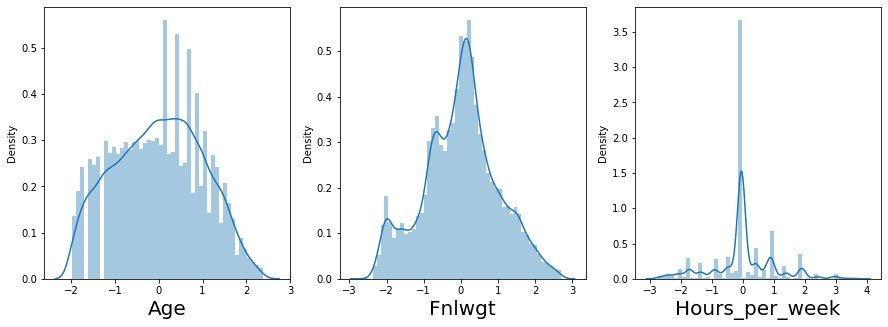

In [89]:
collist=['Age', 'Fnlwgt', 'Hours_per_week']
plt.figure(figsize=(15,5), facecolor='white')
plotnumber = 1

for column in census_income[collist]:
    if plotnumber<=3:
        ax = plt.subplot(1,3,plotnumber)
        sns.distplot(census_income[column])
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.show()

The data is not normal but the skewness has got removed compared to the old data.

## Data preprocessing

### Spliting data into Target and Features:

In [90]:
x=census_income.drop("Income",axis=1)
y=census_income["Income"]

In [91]:
x.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Hours_per_week', 'Native_country'],
      dtype='object')

In [92]:
x.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Hours_per_week,Native_country
0,0.915570,5,-1.114171,9,13,2,3,0,4,1,-2.228173,38
1,0.109856,3,0.427192,11,9,0,5,1,4,1,-0.053366,38
2,1.093043,3,0.607320,1,7,2,5,0,2,1,-0.053366,38
3,-0.729959,3,1.487719,9,13,2,9,5,2,0,-0.053366,4
4,0.034167,3,1.048962,12,14,2,3,5,4,0,-0.053366,38


In [93]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Income, dtype: int32

In [94]:
x.shape, y.shape

((31461, 12), (31461,))

In [95]:
y.value_counts()

0    23853
1     7608
Name: Income, dtype: int64

The data is not balanced. So, we will use oversampling method to balance it.

## Oversampling using the SMOTE

In [96]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [97]:
SM = SMOTE()
x, y = SM.fit_resample(x,y)

In [98]:
y.value_counts()

0    23853
1    23853
Name: Income, dtype: int64

After using oversampling method, we check that now our data is balanced.

<AxesSubplot:xlabel='Income', ylabel='count'>

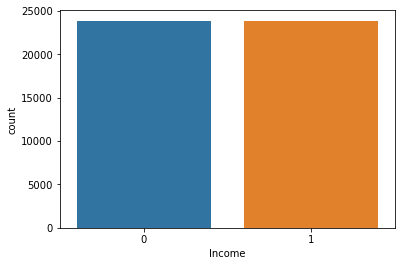

In [99]:
#checking through visualization also
sns.countplot(y)

Now, our data is balanced.

## Scaling data using Standard Scaler

In [100]:
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns = x.columns)

In [101]:
x.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Hours_per_week,Native_country
0,0.818724,1.709395,-1.164516,-0.420271,0.933125,-0.311253,-0.801817,-0.728658,0.364965,0.619213,-2.465994,0.246496
1,-0.058994,-0.054519,0.443964,0.143470,-0.641174,-1.819725,-0.298134,-0.114196,0.364965,0.619213,-0.206657,0.246496
2,1.012056,-0.054519,0.631936,-2.675237,-1.428323,-0.311253,-0.298134,-0.728658,-2.106438,0.619213,-0.206657,0.246496
3,-0.973859,-0.054519,1.550671,-0.420271,0.933125,-0.311253,0.709233,2.343652,-2.106438,-1.614954,-0.206657,-5.502061
4,-0.141446,-0.054519,1.092809,0.425341,1.326699,-0.311253,-0.801817,2.343652,0.364965,-1.614954,-0.206657,0.246496


### Variance Threshold Method

It removes all features which variance doesn't meet some threshold. By default, it removes all zero-variance features.

In [102]:
var_threshold = VarianceThreshold(threshold=0)
var_threshold.fit(x)

VarianceThreshold(threshold=0)

In [103]:
var_threshold.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [104]:
x.columns[var_threshold.get_support()]

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Hours_per_week', 'Native_country'],
      dtype='object')

In [105]:
# taking  out  all the  constant  columns 
cons_columns = [column for column in x.columns
               if column not in x.columns[var_threshold.get_support()]]
print(len(cons_columns))

0


So we can see that, with the help of variance threshold method, we got to know all the features here are important. So now we will check through SelectKBest method.

## SelectKBest method

In [106]:
from sklearn.feature_selection import  SelectKBest, f_classif

In [107]:
best_fit = SelectKBest(score_func = f_classif, k ='all')
fit = best_fit.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

In [109]:
fit = best_fit.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
dfcolumns.head()
featureScores = pd.concat([dfcolumns,dfscores],axis = 1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(12,'Score'))

           Feature        Score
4    Education_num  7991.291122
0              Age  6528.757212
7     Relationship  4898.383352
10  Hours_per_week  4533.268488
5   Marital_status  3867.441175
9              Sex  3280.020856
3        Education   378.993964
8             Race   367.599186
6       Occupation    56.772744
1        Workclass    23.607498
11  Native_country    17.719384
2           Fnlwgt     0.036386


Selecting the best features based on above scores, we can see that the column "Fnlwgt" has most lowest features for the prediction, so we will drop this column.

In [110]:
x = x.drop([ "Fnlwgt"],axis=1)

In [111]:
x.columns

Index(['Age', 'Workclass', 'Education', 'Education_num', 'Marital_status',
       'Occupation', 'Relationship', 'Race', 'Sex', 'Hours_per_week',
       'Native_country'],
      dtype='object')

Now, we have completed features selection process through using 2 techniques. So, will check for multicolinearity now.

## Checking for Multicolinearity

### VIF (Variance Inflation factor)

In [112]:
vif = pd.DataFrame()
vif['VIF values']= [variance_inflation_factor(x.values,i) for i in range(len(x.columns))]
vif['Features'] = x.columns
vif

,VIF values,Features
0,1.206635,Age
1,1.007155,Workclass
2,1.085862,Education
3,1.145688,Education_num
4,1.162091,Marital_status
5,1.015661,Occupation
6,1.971729,Relationship
7,1.041977,Race
8,1.827620,Sex
9,1.157849,Hours_per_week


**No Multi-collinearaity is present in columns. So, we will create model now.**

## Creating Model

**Finding the best random state among all the models**

In [113]:
from sklearn.tree import DecisionTreeClassifier

In [114]:
maxAccu=0
maxRS=0
for i in range(1,100):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.30, random_state =i)
    DTC = DecisionTreeClassifier()
    DTC.fit(x_train, y_train)
    pred = DTC.predict(x_test)
    acc=accuracy_score(y_test, pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print("Best accuracy is ",maxAccu," on Random_state ",maxRS)

Best accuracy is  0.8294438233650084  on Random_state  43


**At random state 54, we are getting best accuracy score i.e., 83%**

## Creating train-test-split

In [115]:
# creating new train test split using the random state.
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=maxRS)

In [116]:
x.shape, y.shape

((47706, 11), (47706,))

In [117]:
x_train.shape,y_train.shape, x_test.shape,y_test.shape

((33394, 11), (33394,), (14312, 11), (14312,))

We can see the x.shape value is divided into x_train.shape and x_test.shape and like this y.shape is also divided. We will understand this by Classification problem.

## Logistic Regression

In [118]:
from sklearn.metrics import confusion_matrix

In [119]:
lr=LogisticRegression()
lr.fit(x_train,y_train)
pred_lr=lr.predict(x_test)

print("accuracy_score: ", accuracy_score(y_test, pred_lr))
print("confusion_matrix: \n", confusion_matrix(y_test, pred_lr))
print("classification_report: \n", classification_report(y_test,pred_lr))

accuracy_score:  0.75
confusion_matrix: 
 [[5198 1919]
 [1659 5536]]
classification_report: 
               precision    recall  f1-score   support

           0       0.76      0.73      0.74      7117
           1       0.74      0.77      0.76      7195

    accuracy                           0.75     14312
   macro avg       0.75      0.75      0.75     14312
weighted avg       0.75      0.75      0.75     14312



Here we are getting 75% accuracy using Logistic Regression.

### Confusion Matrix for Logistic Regression

Text(0.5, 1.0, 'Logistic regressor prediction Confusion_matrix')

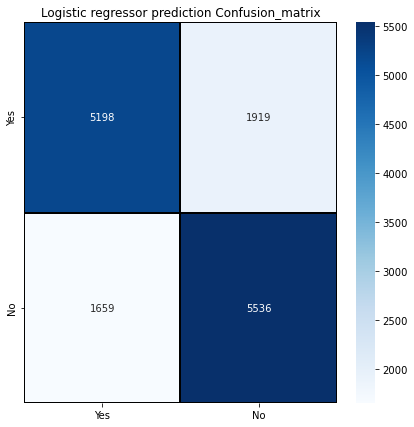

In [120]:
cm = confusion_matrix(y_test,pred_lr)
x_axis_labels = ["Yes","No"]
y_axis_labels = ["Yes","No"]

f , ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, annot = True,linewidths=.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Blues", 
xticklabels=x_axis_labels,
yticklabels=y_axis_labels)
plt.title("Logistic regressor prediction Confusion_matrix")

## Classification Algorithms

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import GradientBoostingClassifier

## Random Forest Classifier

In [122]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train,y_train)
pred_rfc = rfc.predict(x_test)

print("accuracy_score: ",accuracy_score(y_test, pred_rfc))
print("confusion_matrix: \n",confusion_matrix(y_test, pred_rfc))
print("classification_report: \n",classification_report(y_test,pred_rfc))

accuracy_score:  0.8573923979877026
confusion_matrix: 
 [[6048 1069]
 [ 972 6223]]
classification_report: 
               precision    recall  f1-score   support

           0       0.86      0.85      0.86      7117
           1       0.85      0.86      0.86      7195

    accuracy                           0.86     14312
   macro avg       0.86      0.86      0.86     14312
weighted avg       0.86      0.86      0.86     14312



Here we are getting 85% accuracy using Random Forest Classifier.

### Confusion Matrix for RFC

Text(0.5, 1.0, 'RFC prediction Confusion_matrix')

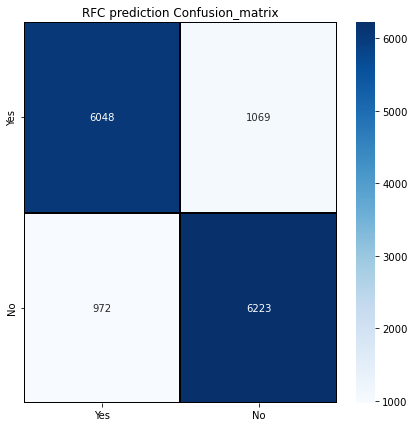

In [123]:
cm = confusion_matrix(y_test,pred_rfc)
x_axis_labels = ["Yes","No"]
y_axis_labels = ["Yes","No"]

f , ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, annot = True,linewidths=.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Blues", 
xticklabels=x_axis_labels,
yticklabels=y_axis_labels)
plt.title("RFC prediction Confusion_matrix")

## Decision Tree Classifier

In [124]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train)
pred_dtc = dtc.predict(x_test)

print("accuracy_score: ",accuracy_score(y_test, pred_dtc))
print("confusion_matrix: \n",confusion_matrix(y_test, pred_dtc))
print("classification_report: \n",classification_report(y_test,pred_dtc))

accuracy_score:  0.8270681945220794
confusion_matrix: 
 [[5961 1156]
 [1319 5876]]
classification_report: 
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      7117
           1       0.84      0.82      0.83      7195

    accuracy                           0.83     14312
   macro avg       0.83      0.83      0.83     14312
weighted avg       0.83      0.83      0.83     14312



Here we are getting 82% accuracy using DTC.

## Confusion Matrix for DTC

Text(0.5, 1.0, 'DTC prediction Confusion_matrix')

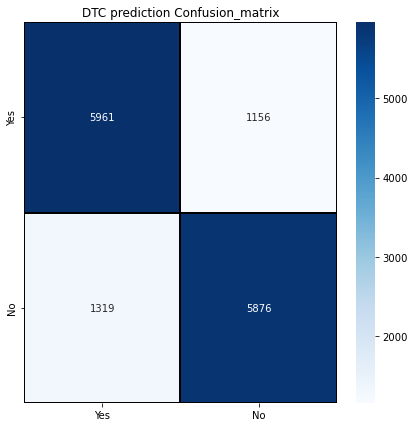

In [125]:
cm = confusion_matrix(y_test,pred_dtc)
x_axis_labels = ["Yes","No"]
y_axis_labels = ["Yes","No"]

f , ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, annot = True,linewidths=.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Blues", 
xticklabels=x_axis_labels,
yticklabels=y_axis_labels)
plt.title("DTC prediction Confusion_matrix")

## Support Vector Machine Classifier

In [126]:
svc = SVC(kernel='linear', gamma=3)
svc.fit(x_train,y_train)
pred_svc = svc.predict(x_test)

print("accuracy_score: ", accuracy_score(y_test, pred_svc))
print("confusion_matrix: \n", confusion_matrix(y_test, pred_svc))
print("classification_report: \n", classification_report(y_test,pred_svc))

accuracy_score:  0.7527948574622694
confusion_matrix: 
 [[5040 2077]
 [1461 5734]]
classification_report: 
               precision    recall  f1-score   support

           0       0.78      0.71      0.74      7117
           1       0.73      0.80      0.76      7195

    accuracy                           0.75     14312
   macro avg       0.75      0.75      0.75     14312
weighted avg       0.75      0.75      0.75     14312



Here we are getting 75% accuracy using SVC.

## Confusion Matrix for SVC

Text(0.5, 1.0, 'SVC prediction Confusion_matrix')

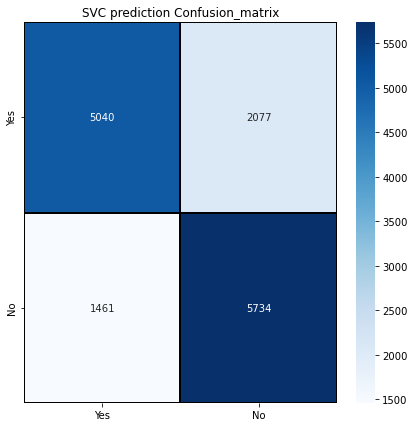

In [127]:
cm = confusion_matrix(y_test,pred_svc)
x_axis_labels = ["Yes","No"]
y_axis_labels = ["Yes","No"]

f , ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, annot = True,linewidths=.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Blues", 
xticklabels=x_axis_labels,
yticklabels=y_axis_labels)
plt.title("SVC prediction Confusion_matrix")

# KNN Classifier

In [128]:
knn = KNN()
knn.fit(x_train,y_train)
pred_knn = knn.predict(x_test)

print("accuracy_score: ",accuracy_score(y_test, pred_knn))
print("confusion_matrix: \n",confusion_matrix(y_test, pred_knn))
print("classification_report: \n",classification_report(y_test,pred_knn))

accuracy_score:  0.8314700950251537
confusion_matrix: 
 [[5592 1525]
 [ 887 6308]]
classification_report: 
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      7117
           1       0.81      0.88      0.84      7195

    accuracy                           0.83     14312
   macro avg       0.83      0.83      0.83     14312
weighted avg       0.83      0.83      0.83     14312



Here we are getting 83% accuracy using KNN.

### Confusion Matrix for KNN classifier

Text(0.5, 1.0, 'KNN prediction Confusion_matrix')

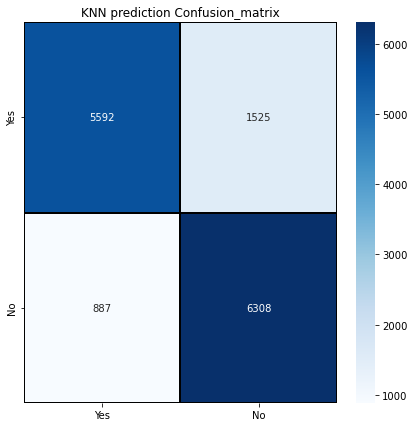

In [129]:
cm = confusion_matrix(y_test,pred_knn)
x_axis_labels = ["Yes","No"]
y_axis_labels = ["Yes","No"]

f , ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, annot = True,linewidths=.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Blues", 
xticklabels=x_axis_labels,
yticklabels=y_axis_labels)
plt.title("KNN prediction Confusion_matrix")

## Gradient Boosting Classifier

In [130]:
gb = GradientBoostingClassifier(n_estimators =100,learning_rate=0.1, max_depth=4)
gb.fit(x_train,y_train)
pred_gb = gb.predict(x_test)

print("accuracy_score: ",accuracy_score(y_test, pred_gb))
print("confusion_matrix: \n",confusion_matrix(y_test, pred_gb))
print("classification_report: \n",classification_report(y_test,pred_gb))

accuracy_score:  0.856484069312465
confusion_matrix: 
 [[5863 1254]
 [ 800 6395]]
classification_report: 
               precision    recall  f1-score   support

           0       0.88      0.82      0.85      7117
           1       0.84      0.89      0.86      7195

    accuracy                           0.86     14312
   macro avg       0.86      0.86      0.86     14312
weighted avg       0.86      0.86      0.86     14312



Here we are getting 85% accuracy using SVC.

### Confusion Matrix for Gradient Boosting classifier

Text(0.5, 1.0, 'Gradient Boosting classifier prediction Confusion_matrix')

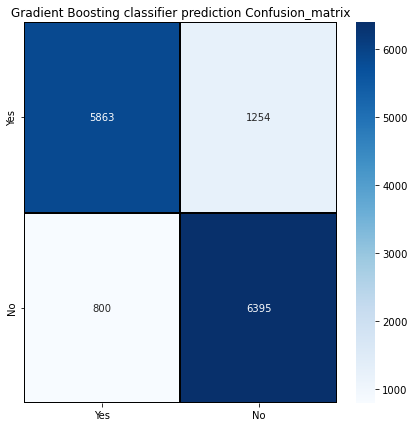

In [131]:
cm = confusion_matrix(y_test,pred_gb)
x_axis_labels = ["Yes","No"]
y_axis_labels = ["Yes","No"]

f , ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, annot = True,linewidths=.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Blues", 
xticklabels=x_axis_labels,
yticklabels=y_axis_labels)
plt.title("Gradient Boosting classifier prediction Confusion_matrix")

# Cross Validation Score for all the model

### CV Score for Logistic Regression

In [132]:
print('CV score for Logistic Regression: ',cross_val_score(lr,x,y,cv=5).mean())

CV score for Logistic Regression:  0.7501992712627612


### CV Score for Random Forest Classifier

In [133]:
print('CV score for Random forest Classifier: ',cross_val_score(rfc,x,y,cv=5).mean())

CV score for Random forest Classifier:  0.8585307360080909


### CV Score for Decision Tree Classifier

In [134]:
print('CV score for Decision Tree Classifier: ',cross_val_score(dtc,x,y,cv=5).mean())

CV score for Decision Tree Classifier:  0.8218485055978885


### CV Score for Support Vector Classifier

In [135]:
print('CV score for Support Vector  Classifier: ',cross_val_score(svc,x,y,cv=5).mean())

CV score for Support Vector  Classifier:  0.7532177524786792


### CV Score for KNN Classifier

In [136]:
print('CV score for KNN Classifier: ',cross_val_score(knn,x,y,cv=5).mean())

CV score for KNN Classifier:  0.8341723309945355


### CV Score for Gradient Boosting Classifier

In [137]:
print('CV score for Gradient Boosting Classifier: ',cross_val_score(gb,x,y,cv=5).mean())

CV score for Gradient Boosting Classifier:  0.8492235355049991


From the observation of accuracy and cross validation score and their difference we can predict that Random Forest Classifier is the best model.

### ROC & AUC Curve for all model

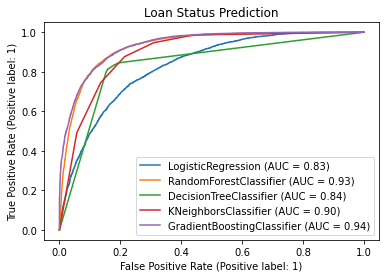

In [138]:
#Lets plot roc curve and check auc and performance of all algorithms
from sklearn.metrics import plot_roc_curve
disp = plot_roc_curve(lr, x_test, y_test)
plot_roc_curve(rfc, x_test, y_test, ax = disp.ax_)
plot_roc_curve(dtc, x_test, y_test, ax = disp.ax_)
plot_roc_curve(knn, x_test, y_test, ax = disp.ax_)
plot_roc_curve(gb, x_test, y_test, ax = disp.ax_)
plt.title("Loan Status Prediction")
plt.legend(prop={"size" :10} ,loc = 'lower right')
plt.show()

Based on the Accuracy Score and Cross-validation Score and performance of the model we will select Random Forest Classifier as the best model compare to Gradient Boosting Classifier.


## Hyper parameter tuning for best model using GridsearchCV

In [139]:
from sklearn.metrics import make_scorer, precision_score, recall_score

In [140]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = .30, random_state = 42)

In [141]:
rfc=RandomForestClassifier(random_state=30)

In [142]:
grid_params = {
                'criterion':['gini','entropy'],
                'max_depth': [15,20,22],
                'n_estimators':[700,900,1000],
                'min_samples_leaf': [1]
                }

In [143]:
CV_rfc = GridSearchCV(RandomForestClassifier(), grid_params, cv = 5)

In [144]:
CV_rfc.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [15, 20, 22], 'min_samples_leaf': [1],
                         'n_estimators': [700, 900, 1000]})

In [145]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 1,
 'n_estimators': 1000}

In [146]:
Census_Income=RandomForestClassifier(random_state=50, max_features='auto', n_estimators= 100, max_depth=8, criterion='gini')
Census_Income.fit(x_train,y_train)
predict=Census_Income.predict(x_test)
print("accuracy score: ",accuracy_score(y_test,predict))
print("confusion_matrix: \n",confusion_matrix(y_test,predict))
print("classification_report: \n",classification_report(y_test,predict))

accuracy score:  0.8242034656232532
confusion_matrix: 
 [[5439 1718]
 [ 798 6357]]
classification_report: 
               precision    recall  f1-score   support

           0       0.87      0.76      0.81      7157
           1       0.79      0.89      0.83      7155

    accuracy                           0.82     14312
   macro avg       0.83      0.82      0.82     14312
weighted avg       0.83      0.82      0.82     14312



In [147]:
acc=accuracy_score(y_test,pred)
print(acc*100)

48.97987702627166


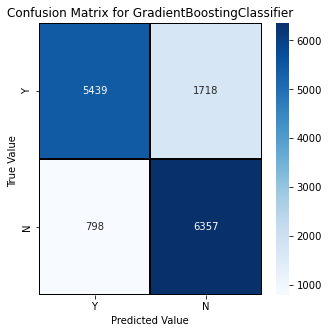

In [148]:
cm = confusion_matrix(y_test, predict)

x_axis_labels = ["Y","N"]
y_axis_labels = ["Y","N"]

f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Blues", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("Predicted Value")
plt.ylabel("True Value ")
plt.title('Confusion Matrix for GradientBoostingClassifier')
plt.show()

## ROC-AUC Curve

In [149]:
fpr, tpr, threshold = roc_curve(y_test,predict)
auc = roc_auc_score(y_test,predict)

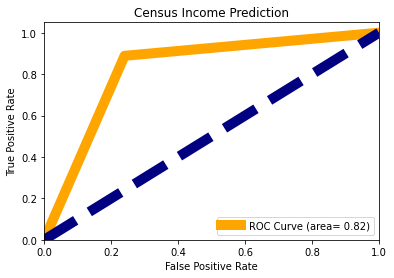

In [150]:
plt.figure()
plt.plot(fpr,tpr,color="orange",lw=10,label="ROC Curve (area= %0.2f)" % auc)
plt.plot([0,1],[0,1],color="navy",lw=10,linestyle="--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Census Income Prediction")
plt.legend(loc="lower right")
plt.show()

This is the AUC-ROC curve for the models which is plotted False positive rate against True positive rate. So the best model has the area under curve as 0.82.

## Saving the Model

In [151]:
import pickle
filename='Census_Income_Project.pickle'
pickle.dump(CV_rfc,open(filename,'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict(x_test)

array([0, 0, 0, ..., 1, 1, 1])

## Checking predicted and original values

In [152]:
a =np.array(y_test)
predicted=np.array(CV_rfc.predict(x_test))
Census_Income_Project=pd.DataFrame({'Orginal':a,'Predicted':predicted}, index=range(len(a)))
Census_Income_Project

,Orginal,Predicted
0,1,0
1,0,0
2,0,0
3,1,0
4,1,1
...,...,...
14307,1,1
14308,1,1
14309,1,1
14310,1,1


As we can see, predicted and original values matches approx 100%.

In [153]:
model =Census_Income_Project.to_csv('Census_Income_Project.csv')
model

**Model Prediction saved in CSV format**